# <center>Entrenar y evaluar una red neuronal convolucional para resolver un problema de clasificación de imágenes</center>

Generalmente, cuando se trata de datos de imagen, texto, audio o vídeo, se pueden utilizar paquetes python estándar que cargan datos en un arreglo numpy. Luego se puede convertir este arreglo en un torch.*Tensor.

- Para las imágenes, paquetes como Pillow, OpenCV son útiles
- Para audio, paquetes como scipy y librosa
- Para el texto, es útil la carga basada en Python o Cython en bruto, o NLTK y SpaCy.

Específicamente para la visión, existe un paquete llamado torchvision, que tiene cargadores de datos para conjuntos de datos comunes como Imagenet, CIFAR10, MNIST, etc. y transformadores de datos para imágenes, a saber, torchvision.datasets y torch.utils.data.data.loader.

Para este tutorial, utilizaremos el conjunto de datos CIFAR10. Tiene las clases: 'avión', 'automóvil', 'pájaro', 'gato', 'ciervo', 'perro', 'rana', 'caballo', 'barco', 'camión'. Las imágenes en CIFAR-10 son de tamaño 3x32x32, es decir, imágenes en color de 3 canales de 32x32 píxeles de tamaño: https://www.cs.toronto.edu/~kriz/cifar.html

<img src="cifar10.png"></img>

Haremos los siguientes pasos en orden:

- Cargar y normalizar los conjuntos de datos de entrenamiento y pruebas CIFAR10 utilizando torchvision.
- Configurar una red neuronal de convolución
- Definir una función de pérdida
- Optimizar la red sobre los datos de entrenamiento
- Probar la red con los datos de test

## 1. Cargar y normalizar el dataset CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

#The output of torchvision datasets are PILImage images of range [0, 1]. 
#We transform them to Tensors of normalized range [-1, 1].

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


El código siguiente permite mostrar imagenes aleatorias del dataset de entrenamiento y su etiqueta real:

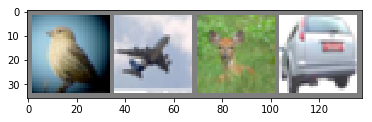

 bird plane  deer   car


In [27]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def imagesFromBatches(iterator,quantity):
    dataiter = iter(iterator)
    images, labels = dataiter.next()    
    imshow(torchvision.utils.make_grid(images))
    print(' '.join('%5s' % classes[labels[j]] for j in range(quantity)))
    return (images,labels)

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Configurar la CNN

In [41]:
import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 24, 10, 10]           3,624
         MaxPool2d-4             [-1, 24, 5, 5]               0
            Linear-5                  [-1, 120]          72,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 87,214
Trainable params: 87,214
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.33
Estimated Total Size (MB): 0.41
----------------------------------------------------------------


<b>Preguntas:</b>

1) ¿Cuántas capas tiene nuestra CNN?

2) Explicar los parametros de cada capa. ¿Cuántos filtros se utilizan en las capas de convolución? ¿Cuál es el tamaño de los filtros?

3) ¿Cuál es la diferencia entre la función <code>init</code> y <code>forward</code>?

4) ¿De qué sirve la función view()? Explicar sus parametros.

5) ¿Cuántos paramétros tenemos que aprender en cada capa?

6) ¿Por qué se utiliza la función <code>conv2d</code> aunque tenemos imagenes con 3 canales? ¿Con qué tipo de datos se puede utilizar <code>conv3d</code>?

7) ¿De qué sirve la función summary? ¿Cuáles son sus parametros?

## 3. Entrenar la CNN

In [42]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [43]:
for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.189
[1,  4000] loss: 1.832
[1,  6000] loss: 1.656
[1,  8000] loss: 1.552
[1, 10000] loss: 1.498
[1, 12000] loss: 1.426
[2,  2000] loss: 1.341
[2,  4000] loss: 1.315
[2,  6000] loss: 1.285
[2,  8000] loss: 1.264
[2, 10000] loss: 1.225
[2, 12000] loss: 1.224
[3,  2000] loss: 1.149
[3,  4000] loss: 1.133
[3,  6000] loss: 1.096
[3,  8000] loss: 1.118
[3, 10000] loss: 1.110
[3, 12000] loss: 1.086
[4,  2000] loss: 1.003
[4,  4000] loss: 1.006
[4,  6000] loss: 1.017
[4,  8000] loss: 1.016
[4, 10000] loss: 1.012
[4, 12000] loss: 1.009
Finished Training


<b>Preguntas:</b>

1) ¿Cuál es la función de perdida utilizada?

2) ¿Qué devuelve el método CrossEntropyLoss()?

3) ¿Qué proceso de optimización se utiliza?

4) ¿Qué diferencia existe entre el método de optimización GD y SGD?

5) ¿A qué corresponde el concepto de <i>epoch</i>?

6) ¿Podría ser útil aumentar el número de epoch? ¿Por qué?

7) ¿De qué sirve el parametro <code>momentum</code> del método SGD?

## 4. Evaluar la CNN

Tomamos 4 ejemplos del dataset de test:

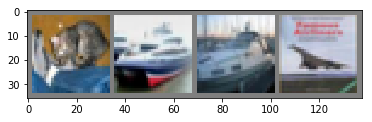

  cat  ship  ship plane


In [44]:
BatchSize=4

images,labels= imagesFromBatches(testloader,BatchSize)

Clasificamos estas 4 imágenes con nuestra CNN: 

In [45]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car   car plane


¿Cuál es rendimiento de nuestra CNN sobre estos 4 primeros ejemplos?

Calculamos el rendimiento de nuestra CNN sobre todos los datos del training set:

In [46]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 62 %


Miramos el rendimiento de la CNN calculando su exactitud según cada etiqueta:

In [47]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 71 %
Accuracy of   car : 75 %
Accuracy of  bird : 44 %
Accuracy of   cat : 43 %
Accuracy of  deer : 57 %
Accuracy of   dog : 47 %
Accuracy of  frog : 66 %
Accuracy of horse : 81 %
Accuracy of  ship : 67 %
Accuracy of truck : 70 %


<b>Preguntas:</b>

1) ¿Qué paramétros podrían modificar para tratar de mejorar el rendimiento del CNN?

2) ¿Qué pasa si tratan de agregar más filtros en la segunda capa de convolución?

3) ¿Qué pasa si trata de agregar una tercera capa de convolución y pooling?

4) Proponer una CNN para resolver la clasificación de imagenes del dataset MNIST